In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


- vocab_size = 8000
- 전체 파라미터 사이즈 : 1M
- 10 epochs 학습시킨 모델 만들기


# 1. Tokenizer 준비
- SentencePiece 모델을 이용하여 BERT MLM 학습용 데이터 만들기
- vocab_size = 8000 인 sentencepiece 모델 만들기
- BERT 에 사용되는 주요 특수문자가 vocab에 포함되어야 한다. 


In [2]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'
corpus_file = os.getenv('HOME') + '/aiffel/bert_pretrain/data/kowiki.txt'
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load("./ko_8000.model")

True

In [3]:
# vocab_size = 8000인 sentencepiece 모델
spm.SentencePieceTrainer.train(
    input=corpus_file,
    model_prefix='ko_8000',
    vocab_size=8000,
    model_type="bpe",
    max_sentence_length=999999,
    pad_id=0,
    pad_piece="[PAD]",
    unk_id=1,
    unk_piece="[UNK]",
    bos_id=2,
    bos_piece="[BOS]",
    eos_id=3,
    eos_piece="[EOS]",
    user_defined_symbols="[SEP],[CLS],[MASK]"
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/bert_pretrain/data/kowiki.txt
  input_format: 
  model_prefix: ko_8000
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [SEP]
  user_defined_symbols: [CLS]
  user_defined_symbols: [MASK]
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: [UNK]
  bos_piece: [BOS]
  eos_piece: [EOS]
  pad_piece: [P

In [3]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load("./ko_8000.model")

True

In [4]:
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            token = vocab.id_to_piece(id)
            vocab_list.append(token)
vocab_list[:30]

['▁1',
 '▁이',
 '으로',
 '에서',
 '▁있',
 '▁2',
 '▁그',
 '▁대',
 '▁사',
 '이다',
 '었다',
 '▁지',
 '▁수',
 '▁19',
 '▁가',
 '▁시',
 '▁20',
 '▁기',
 '▁전',
 '▁아',
 '▁하',
 '▁있다',
 '▁다',
 '▁제',
 '했다',
 '하였',
 '▁일',
 '▁한',
 '▁중',
 '▁정']

In [5]:
# [CLS], tokens a, [SEP], token b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


# 2. 데이터 전처리 (1) MASK 생성
- MLM에 필요한 빈칸(mask)를 전체 토큰의 15%  

    -> 그중 80% [MASK}, 10% 랜덤한 토큰, 10%는 원래 토큰


In [6]:
# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt

14

In [7]:
# 띄어쓰기 단위로 mask 하기 위한 index 분할
cand_idx = []  # word 단위의 index array
for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
        cand_idx[-1].append(i)
    else:
        cand_idx.append([i])

# 결과확인
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1, 2, 3, 4] ['▁추', '적', '추', '적']
[5, 6] ['▁비', '가']
[7, 8] ['▁내', '리는']
[9, 10, 11] ['▁날', '이었', '어']
[12, 13, 14] ['▁그', '날', '은']
[15, 16, 17] ['▁', '왠', '지']
[18, 19, 20] ['▁손', '님', '이']
[21, 22] ['▁많', '아']
[23] ['▁첫']
[24, 25] ['▁번', '에']
[26, 27] ['▁삼', '십']
[28] ['▁전']
[29, 30, 31] ['▁둘', '째', '번']
[32, 33] ['▁오', '십']
[34] ['▁전']
[35, 36, 37] ['▁오', '랜', '만에']
[38, 39, 40] ['▁받아', '보', '는']
[41] ['▁십']
[42, 43, 44] ['▁전', '짜', '리']
[45, 46, 47] ['▁백', '통', '화']
[48, 49, 50] ['▁서', '푼', '에']
[52, 53, 54] ['▁손', '바', '닥']
[55, 56] ['▁위', '엔']
[57, 58, 59] ['▁기', '쁨', '의']
[60, 61] ['▁눈', '물이']
[62, 63] ['▁흘', '러']
[64, 65, 66] ['▁컬', '컬', '한']
[67, 68] ['▁목', '에']
[69, 70] ['▁모', '주']
[71, 72, 73] ['▁한', '잔', '을']
[74, 75] ['▁적', '셔']
[76] ['▁몇']
[77] ['▁달']
[78] ['▁포']
[79, 80] ['▁전', '부터']
[81, 82, 83, 84] ['▁콜', '록', '거', '리는']
[85] ['▁아내']
[86, 87] ['▁생각', '에']
[88, 89, 90] ['▁그', '토', '록']
[91, 92] ['▁먹', '고']
[93, 94, 95] ['▁싶', '다', '던']


In [8]:
# random mask를 위한 index 섞기
random.shuffle(cand_idx)
cand_idx

[[24, 25],
 [57, 58, 59],
 [32, 33],
 [64, 65, 66],
 [41],
 [79, 80],
 [52, 53, 54],
 [67, 68],
 [29, 30, 31],
 [91, 92],
 [23],
 [26, 27],
 [76],
 [42, 43, 44],
 [78],
 [60, 61],
 [38, 39, 40],
 [93, 94, 95],
 [9, 10, 11],
 [81, 82, 83, 84],
 [85],
 [12, 13, 14],
 [34],
 [71, 72, 73],
 [77],
 [45, 46, 47],
 [48, 49, 50],
 [28],
 [74, 75],
 [62, 63],
 [88, 89, 90],
 [5, 6],
 [35, 36, 37],
 [55, 56],
 [18, 19, 20],
 [86, 87],
 [7, 8],
 [15, 16, 17],
 [1, 2, 3, 4],
 [21, 22],
 [69, 70]]

In [9]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

mask_lms = []  # mask 된 값
for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt:  # 현재 mask된 개수가 15%를 넘으면 중지
          break
    if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
          continue
    dice = random.random()  # 0과 1 사이의 확률 값

    for index in index_set:
        masked_token = None
        if dice < 0.8:  # 80% replace with [MASK]
            masked_token = "[MASK]"
        elif dice < 0.9: # 10% keep original
            masked_token = tokens[index]
        else:  # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[MASK]', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MASK]', '[MASK]', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '작', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '[MASK]', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘', '러', '[MASK]', '[MASK]', '[MASK]', '▁목', '에'

In [10]:
# 순서 정렬 및 mask_idx, mask_label 생성
mask_lms = sorted(mask_lms, key=lambda x: x["index"])
mask_idx = [p["index"] for p in mask_lms]
mask_label = [p["label"] for p in mask_lms]

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

mask_idx   : [23, 24, 25, 32, 33, 41, 57, 58, 59, 64, 65, 66, 79, 80]
mask_label : ['▁첫', '▁번', '에', '▁오', '십', '▁십', '▁기', '쁨', '의', '▁컬', '컬', '한', '▁전', '부터']


In [11]:
# create_pretrain_mask() : masked LM 을 위한 코퍼스 생성 메소드
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS}" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581" 단어의 시작을 의미
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]
    return tokens, mask_idx, mask_label

In [12]:
# Masked LM 을 위한 코퍼스 생성 메소드
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS}" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581" 단어의 시작을 의미
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]
    return tokens, mask_idx, mask_label

In [13]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '[MASK]', '▁둘', '째', '번', '▁오', '십', '[MASK]', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '[MASK]', '[MASK]', '[MASK]', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을'

# 3. 데이터 전처리 (2) NSP pair 생성
- NSP -> 두 문장이 연속하는지 확인
- 2개의 문장을 짝지어 50%확률로 True, Fals를 지정
- 두 문장 사이의 segment 처리: 첫번째문장의 segment 0, 두번째 문장은 1, 구분자 [sep]

- MLM과 NSP 는 동시에 학습됨

In [14]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""


# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'],
 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'],
 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전']]

In [15]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [16]:
# 두 문장의 최대 길이를 유지하도록 trim 적용 후 50%의 확률로 true/false 케이스를 생성

def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [17]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
            current_chunk.append(doc[i])  # line 단위로 추가
            current_length += len(doc[i])  # current_chunk의 token 수
            if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
#                 print("current_chunk:", len(current_chunk), current_length, current_chunk)

                # token a
                a_end = 1
                if 1 < len(current_chunk):
                    a_end = random.randrange(1, len(current_chunk))
                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])
                # token b
                tokens_b = []
                for j in range(a_end, len(current_chunk)):
                    tokens_b.extend(current_chunk[j])

                #######################################
                if random.random() < 0.5:  # 50% 확률로 swap
                    is_next = 0     #False
                    tokens_t = tokens_a
                    tokens_a = tokens_b
                    tokens_b = tokens_t
                else:
                    is_next = 1    #True
                # max_seq 보다 큰 경우 길이 조절
                trim_tokens(tokens_a, tokens_b, max_seq)
                assert 0 < len(tokens_a)
                assert 0 < len(tokens_b)

#                 print("is_next:", is_next)
#                 print("tokens_a:", len(tokens_a), tokens_a)
#                 print("tokens_b:", len(tokens_b), tokens_b)
                #######################################
#                 print()

                current_chunk = []
                current_length = 0
    return instances

In [18]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    max_seq = n_seq - 3
    instances = []
    current_chunk = []
    current_length = 0

    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])

        if i == len(doc) - 1 or current_length >= max_seq:
            if current_chunk:
                # token a/b 분리
                a_end = 1
                if len(current_chunk) >= 2:
                    a_end = random.randrange(1, len(current_chunk))
                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])
                tokens_b = []
                for j in range(a_end, len(current_chunk)):
                    tokens_b.extend(current_chunk[j])

                # swap 여부
                if random.random() < 0.5:
                    is_next = 0
                    tokens_a, tokens_b = tokens_b, tokens_a
                else:
                    is_next = 1

                trim_tokens(tokens_a, tokens_b, max_seq)

                tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
                segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

                tokens, mask_idx, mask_label = create_pretrain_mask(
                    tokens, int(len(tokens) * mask_prob), vocab_list)

                input_ids = [vocab.piece_to_id(p) for p in tokens]
                attention_mask = [1] * len(input_ids)

                instance = {
                    "input_ids": input_ids,
                    "segment": segment,
                    "is_next": is_next,
                    "mask_idx": mask_idx,
                    "mask_label": mask_label,
                    "attention_mask": attention_mask
                }
                instances.append(instance)

            current_chunk = []
            current_length = 0

    return instances


In [19]:
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'input_ids': [6, 516, 3740, 4347, 45, 4007, 24, 5524, 3594, 1130, 2574, 3211, 3720, 4, 199, 3650, 3846, 3650, 6, 6, 114, 368, 687, 500, 3626, 6, 6, 6, 3589, 7206, 3603, 516, 4258, 3590, 201, 3623, 6, 254, 3593, 391, 4185, 6, 938, 3975, 254, 64, 4185, 5736, 64, 3974, 2848, 764, 3665, 3595, 2288, 25, 4350, 3615, 456, 3734, 3676, 80, 4802, 4], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [0, 18, 19, 25, 26, 27, 36, 41, 47], 'mask_label': ['[CLS]', '▁비', '가', '▁그', '날', '은', '▁첫', '▁전', '▁전'], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [5, 1623, 6907, 19, 526, 313, 9, 6, 6, 552, 826, 116, 4052, 956, 3904, 3628, 6, 6, 266, 3681

# 4. 데이터 전처리 (3) 데이터셋 완성
- BERT pretrain dataset 생성. json으로 저장
- 데이터 사이즈가 크므로 np.memmap을 사용. 메모리 사용량 최소화

In [20]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [21]:
# 위키가 주제별로 잘 나눠지는지 여부 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)  
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:  # 빈 줄이 아니면 doc에 저장
            pieces = vocab.encode_as_pieces(line)    
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

21 lines : ['▁지', '미', '▁카', '터']
['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카', '터', '▁주', '니어', '(,', '▁192', '4', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '7', '7', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁그는', '▁2002', '년', '▁말', '▁인', '권', '과', '▁중', '재', '▁역할', '에', '▁대한', '▁공', '로를', '▁인정', '받아', '▁노', '벨', '▁평화', '상을', '▁받', '게', '▁되었다', '.']

14 lines : ['▁수학']
['▁수학', '(', '數', '學', ',', '▁)', '은', '▁양', ',', '▁구조', ',', '▁공간', ',', '▁변화', ',', '▁미', '적', '분', '▁등의', '▁개념', '을', '▁다루', '는', '▁학', '문', '이다', '.', '▁현대', '▁수학', '은', '▁형식', '▁논', '리를', '▁이용', '해서', '▁공', '리로', '▁구성된', '▁추', '상', '적', '▁구조를', '▁연구', '하는', '▁학', '문', '으로', '▁여겨', '지', '기도', '▁한다', '.', '▁수학', '은', '▁그', '▁구조', '와', '▁발전', '▁과정', '에서는', '▁자연', '과학', '에', '▁속하는', '▁물리', '학을', '▁비롯한', '▁다른', '▁학', '문', '들과', '▁깊', '은', '▁연', '관을', '▁맺', '고', '▁있다', '.', '▁하지만', ',', '▁어느', '▁과학', '의', '▁분야', '들과', '는', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지',

In [22]:
# instance 생성 기능 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # 테스트를 위해서 부분 처리함
                    count -= 1
                else:
                    break
        else:  # doc에 저장
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

doc: 21 instances: 21
{'input_ids': [5, 4, 46, 3607, 3676, 3678, 3606, 812, 2661, 2371, 6, 6, 6, 470, 38, 147, 3637, 16, 3592, 1230, 46, 3607, 268, 3807, 3760, 3606, 3454, 292, 1776, 612, 199, 3764, 3638, 4162, 268, 3807, 1408, 2453, 5590, 1161, 3606, 6, 6, 268, 3807, 2181, 803, 2133, 1153, 1342, 3427, 812, 3681, 6180, 6175, 343, 812, 3681, 70, 402, 1219, 484, 268, 4], 'segment': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [10, 11, 12, 37, 38, 41, 42, 53, 54], 'mask_label': ['▁화', '합', '물을', '▁뜻', '하였으나', '▁유', '기', '▁사', '슬'], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [5, 4, 46, 3607, 3676, 3678, 3606, 812, 2661, 6, 268, 3807, 1408

In [23]:
# BERT pretrain 데이터셋 생성 메소드
# Q. 아래 주석에 따라 코드를 완성해주세요.
# Q. 아래 주석에 따라 코드를 완성해주세요.
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                     if len(doc) > 0:
                         save_pretrain_instances(out_f, doc)
                         doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode(line, out_type = str)
                    if len(pieces) > 0:
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)

In [41]:
# json 포맷으로 저장
pretrain_json_path ='./bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [ ]:
# json 포맷으로 저장(chunk 단위로 나눠서 처리)

In [23]:
# import json

# def make_pretrain_data_batch(sp, corpus_file, output_prefix, seq_len, batch_size=100000):
#     with open(corpus_file, 'r', encoding='utf-8') as f:
#         buffer = []
#         file_index = 0
#         for i, line in enumerate(f):
#             # SentencePiece를 사용한 토크나이징 및 ID 변환
#             ids = sp.encode(line.strip(), out_type=int)[:seq_len]
#             attention = [1] * len(ids)
#             # 패딩 추가 (필요한 경우)
#             if len(ids) < seq_len:
#                 pad_len = seq_len - len(ids)
#                 ids += [sp.pad_id()] * pad_len
#                 attention += [0] * pad_len

#             data = {
#                 'input_ids': ids,
#                 'attention_mask': attention
#             }
#             buffer.append(data)

#             if len(buffer) >= batch_size:
#                 out_file = f"{output_prefix}_{file_index:03d}.json"
#                 with open(out_file, 'w', encoding='utf-8') as out_f:
#                     json.dump(buffer, out_f, ensure_ascii=False)
#                 print(f"✅ Saved: {out_file}")
#                 buffer = []
#                 file_index += 1

#         if buffer:
#             out_file = f"{output_prefix}_{file_index:03d}.json"
#             with open(out_file, 'w', encoding='utf-8') as out_f:
#                 json.dump(buffer, out_f, ensure_ascii=False)
#             print(f"✅ Saved: {out_file} (last)")

# # 사용 예시
# import sentencepiece as spm
# sp = spm.SentencePieceProcessor()
# sp.load("./ko_8000.model")  # 학습된 모델 경로로 바꿔주세요

# make_pretrain_data_batch(sp, corpus_file, './bert_pretrain_chunk', 128, batch_size=100000)


In [24]:
# memmap을 사용하여 메모리 사용량 최소화
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [25]:
import json
import glob

# # 모든 chunk 파일들을 jsonl로 변환
# for path in sorted(glob.glob("./bert_pretrain_chunk/bert_pretrain_chunk_*.json")):
#     with open(path, "r", encoding="utf-8") as f_in:
#         data_list = json.load(f_in)  # list of dicts
#     jsonl_path = path.replace(".json", ".jsonl")
#     with open(jsonl_path, "w", encoding="utf-8") as f_out:
#         for item in data_list:
#             f_out.write(json.dumps(item, ensure_ascii=False) + "\n")
#     print(f"✅ Converted to JSONL: {jsonl_path}")


In [26]:
# 라인수
pretrain_json_path = './bert_pre_train.json'
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

1095914

In [27]:
# import os
# import glob

# pretrain_json_path = './bert_pretrain_chunk/'
# total = 0

# for file_path in glob.glob(os.path.join(pretrain_json_path, "*.json")):
#     with open(file_path, "r", encoding="utf-8") as f:
#         for _ in f:
#             total += 1

# print("총 라인 수:", total)


In [28]:
# 학습에 필요한 데이터 로딩 함수 load_pre_train_data()
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = data["input_ids"]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)


In [29]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

/tmp/ipykernel_62/2100616155.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_62/2100616155.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

data load early stop 128000 128000


In [30]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   6,   18, 3679,  207, 3707,    6, 1042,  103, 3603, 3679, 3711,
          207, 3707,   37, 3418,  416,  810, 3659, 3618,    6,    6,    7,
         3622,    6,    6,    6, 1114, 3717,  788,  243,   49, 3625,  796,
            6, 1647, 3675, 3675, 3618,    6, 3008, 3618, 3609,   16, 3592,
            4,   18, 3679,  207, 3707, 3595, 1755, 3623, 3639,    6,    6,
         3565, 3828, 4396,  794, 6077, 5810, 1369,   10, 1605, 3592, 1755,
         3623,   41, 3637,  830, 3617, 1135,   52, 3592,   13,    6,   87,
         1501, 2247,   25, 3772, 3866, 3660, 3624, 3806, 3866, 4189, 3629,
         3772, 3594,  249, 3718, 1232,    6,    6,    6,  479, 3645, 3618,
          243, 2780,   14, 1509,  168, 3870,  414,  165, 1697, 4283, 3866,
         3696, 3676,  593,   21, 5000,  399, 1927, 3600,  813,   17, 3592,
          307,  587,  931,  103, 4306, 4283,    4], dtype=int32),
 memmap([   5, 3662,  205, 3592,    6,    6,    6,  143, 3655,   19, 3688,
         3613,  338, 3708, 4034, 3

# 5. BERT 모델 구현
- pad mask, ahead mask 함수
- gelu activation 함수
- parameter initializer 생성 함수
- json을 config 형태로 사용하기 위한 유틸리티 함수  


- embedding layer, transformer encoder layer, bert layer 구성
- pretrain용 BERT 모델 구현

In [31]:
# pad mask, ahead mask 함수
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask
print("슝=3")

슝=3


In [32]:
# gelu activation 함수
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

print("슝=3")

슝=3


In [33]:
# parameter initializer 함수

def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer
print("슝=3")

슝=3


In [34]:
#json을 config 형태로 사용하기 위한 class
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("슝=3")

슝=3


In [35]:
#Token Embedding 
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
print("슝=3")

슝=3


In [36]:
# positional embedding 
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed
print("슝=3")

슝=3


In [37]:
# segment embedding은 별도의 레이어로 구현하지 않고 bert class에 포함하도록 구성
# scaled dot attention
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out, attn_prob
print("슝=3")

슝=3


In [38]:
# multihead attention
# Q. 주석과 코드를 참조하여 아래 클래스를 완성해주세요.
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out, _ = self.attention(Q_m, K_m, V_m, attn_mask_m)
        # transpose and liner
        attn_out_m =  tf.transpose(attn_out, perm = [0, 2, 1, 3]) # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
print("슝=3")

슝=3


In [39]:
# transformer encoder layer
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
print("슝=3")

    
    
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
print("슝=3")

슝=3
슝=3


In [40]:
# bert layer
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed
print("슝=3")

슝=3


In [41]:
# pretrain용 모델 구성
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs
print("슝=3")
    
def build_model_pre_train(config):
    enc_tokens = tf.keras.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    segments = tf.keras.Input(shape=(128,), dtype=tf.int32, name="segment_ids")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model
print("슝=3")

슝=3
슝=3


# 6. pretrain 진행
- loss, accuracy 함수 정의
- learning rate 스케쥴링
- 10 epoch 모델 학습


In [42]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴
print("슝=3")

슝=3


In [43]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy
print("슝=3")

슝=3


In [44]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
print("슝=3")

슝=3


In [45]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8000,
 'i_pad': 0}

In [46]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4483840     input_ids[0][0]                  
                                                                 segment_ids[0][0]                
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                   

In [47]:
print(config.d_model)
print(config.n_head)
print(config.d_head)

256
4
64


In [48]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [49]:
# Q. 모델을 학습시키고, 내용을 history에 담아주세요.
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint("./bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(x = pre_train_inputs, y = pre_train_labels, epochs = 10, batch_size=32, callbacks = [save_weights])
# 모델 인자에는 inputs, labels, epochs, batch size, callback 이 필요해요.

Epoch 1/10
4000/4000 [==============================] - 329s 72ms/step - loss: 19.0922 - nsp_loss: 0.5273 - mlm_loss: 18.5649 - nsp_acc: 0.7536 - mlm_lm_acc: 0.1242

Epoch 00001: mlm_lm_acc improved from -inf to 0.12420, saving model to ./bert_pre_train.hdf5
Epoch 2/10
4000/4000 [==============================] - 289s 72ms/step - loss: 17.2878 - nsp_loss: 0.4900 - mlm_loss: 16.7978 - nsp_acc: 0.7938 - mlm_lm_acc: 0.1441

Epoch 00002: mlm_lm_acc improved from 0.12420 to 0.14413, saving model to ./bert_pre_train.hdf5
Epoch 3/10
4000/4000 [==============================] - 290s 73ms/step - loss: 15.1288 - nsp_loss: 0.4862 - mlm_loss: 14.6425 - nsp_acc: 0.8011 - mlm_lm_acc: 0.1786

Epoch 00003: mlm_lm_acc improved from 0.14413 to 0.17857, saving model to ./bert_pre_train.hdf5
Epoch 4/10
4000/4000 [==============================] - 290s 73ms/step - loss: 14.1209 - nsp_loss: 0.4782 - mlm_loss: 13.6427 - nsp_acc: 0.8132 - mlm_lm_acc: 0.2026

Epoch 00004: mlm_lm_acc improved from 0.17857 to 0.

# 7. 결과
- 학습 과정 시각화(NSP와 MLM의 loss)
- inference model
    - masked token 예측
    - NSP 판단


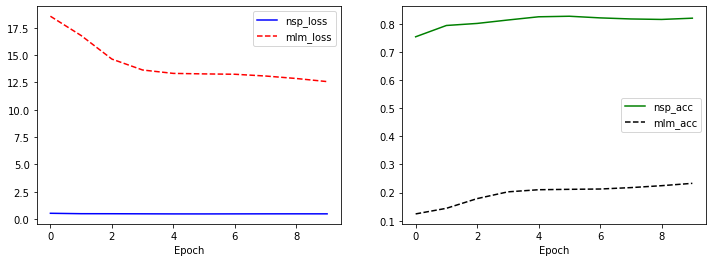

In [76]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

- nsp:처음 부터 높고 빠르게 수럼 -> nsp task가 너무 쉬움, nsp 쌍을 더 균형있게 섞는다. 
- mlm :

### inference model

In [77]:
def build_nsp_inference_model(pre_train_model):
    input_ids = pre_train_model.input[0]
    segment_ids = pre_train_model.input[1]
    nsp_output = pre_train_model.get_layer('nsp').output

    inference_model = tf.keras.Model(inputs=[input_ids, segment_ids], outputs=nsp_output)
    return inference_model


def build_mlm_inference_model(pre_train_model):
    input_ids = pre_train_model.input[0]
    segment_ids = pre_train_model.input[1]
    mlm_output = pre_train_model.get_layer('mlm').output

    inference_model = tf.keras.Model(inputs=[input_ids, segment_ids], outputs=mlm_output)
    return inference_model


In [78]:
# 학습 모델 생성 및 가중치 로드
pre_train_model = build_model_pre_train(config)
pre_train_model.load_weights("bert_pre_train.hdf5")

# 추론 모델 생성
nsp_model = build_nsp_inference_model(pre_train_model)
mlm_model = build_mlm_inference_model(pre_train_model)

# # 예측 실행
# nsp_pred = nsp_model.predict([input_ids, segment_ids])
# mlm_pred = mlm_model.predict([input_ids, segment_ids])


In [79]:
import numpy as np

def make_nsp_input(text_a, text_b, vocab, max_len=128):
    tokens_a = vocab.encode(text_a, out_type=str)
    tokens_b = vocab.encode(text_b, out_type=str)

    tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
    segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

    input_ids = [vocab.piece_to_id(t) for t in tokens]

    pad_len = max_len - len(input_ids)
    input_ids += [vocab.pad_id()] * pad_len
    segment_ids += [0] * pad_len

    return np.array([input_ids]), np.array([segment_ids])

def make_mlm_input(masked_text, vocab, max_len=128):
    tokens = vocab.encode(masked_text, out_type=str)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    input_ids = [vocab.piece_to_id(t) for t in tokens]
    segment_ids = [0] * len(input_ids)

    pad_len = max_len - len(input_ids)
    input_ids += [vocab.pad_id()] * pad_len
    segment_ids += [0] * pad_len

    return np.array([input_ids]), np.array([segment_ids]), tokens


In [80]:
def test_nsp(text_a, text_b, vocab, model, max_len=128):
    # tokenize
    tokens_a = vocab.encode(text_a, out_type=str)
    tokens_b = vocab.encode(text_b, out_type=str)

    tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
    segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

    input_ids = [vocab.piece_to_id(t) for t in tokens]

    # pad
    pad_len = max_len - len(input_ids)
    input_ids += [vocab.pad_id()] * pad_len
    segment_ids += [0] * pad_len

    # to array
    input_ids = np.array([input_ids])
    segment_ids = np.array([segment_ids])

    # inference
    pred = model.predict([input_ids, segment_ids])
    prob = pred["nsp"][0]

    print(f"[NSP] 이어질 확률: {prob[0]:.4f}, 이어지지 않을 확률: {prob[1]:.4f}")


In [81]:
# NSP 예문
nsp_pairs = [
    ("세종대왕은 조선의 제4대 왕이다.", "한글은 세종대왕이 창제하였다."),  #연속
    ("경복궁은 조선 시대의 궁궐 중 하나이다.", "아인슈타인은 상대성 이론으로 유명한 물리학자이다.")  # 비연속
]

# MLM 예문
mlm_sentences = [
    "지미카터는 [MASK] 출신의 대통령이다",
    "백두산은 [MASK]와 중국의 국경에 위치해 있다.",
    "지구는 태양계에서 [MASK] 번째 행성이다."
]


In [82]:
# NSP 추론
print("🔎 NSP 결과")
for i, (a, b) in enumerate(nsp_pairs):
    input_ids, segment_ids = make_nsp_input(a, b, vocab)
    pred = nsp_model.predict([input_ids, segment_ids])[0]
    print(f"[{i+1}] \"{a}\" / \"{b}\" → {pred} (is_next 확률: {pred[1]:.4f})")

# MLM 추론
print("\n🔎 MLM 결과")
for i, sentence in enumerate(mlm_sentences):
    input_ids, segment_ids, tokens = make_mlm_input(sentence, vocab)
    pred = mlm_model.predict([input_ids, segment_ids])[0]

    masked_idx = tokens.index("[MASK]")
    predicted_id = np.argmax(pred[masked_idx])
    predicted_token = vocab.id_to_piece(int(predicted_id))

    print(f"[{i+1}] \"{sentence}\" → [MASK] 예측: \"{predicted_token}\"")


🔎 NSP 결과
[1] "세종대왕은 조선의 제4대 왕이다." / "한글은 세종대왕이 창제하였다." → [0.73093045 0.26906958] (is_next 확률: 0.2691)
[2] "경복궁은 조선 시대의 궁궐 중 하나이다." / "아인슈타인은 상대성 이론으로 유명한 물리학자이다." → [0.27081448 0.72918546] (is_next 확률: 0.7292)

🔎 MLM 결과
[1] "지미카터는 [MASK] 출신의 대통령이다" → [MASK] 예측: "▁러시아"
[2] "백두산은 [MASK]와 중국의 국경에 위치해 있다." → [MASK] 예측: "▁km"
[3] "지구는 태양계에서 [MASK] 번째 행성이다." → [MASK] 예측: "▁세"


In [75]:
import matplotlib.pyplot as plt

def visualize_nsp(text_a, text_b, vocab, model, max_len=128):
    # 기존 test_nsp의 핵심 로직
    tokens_a = vocab.encode(text_a, out_type=str)
    tokens_b = vocab.encode(text_b, out_type=str)
    tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
    segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
    input_ids = [vocab.piece_to_id(t) for t in tokens]
    pad_len = max_len - len(input_ids)
    input_ids += [vocab.pad_id()] * pad_len
    segment_ids += [0] * pad_len
    input_ids = np.array([input_ids])
    segment_ids = np.array([segment_ids])

    # 모델 예측
    pred = model.predict([input_ids, segment_ids])
    prob = pred["nsp"][0]

    # 시각화
    labels = ["Is Next", "Not Next"]
    plt.figure(figsize=(5, 3))
    plt.bar(labels, prob, color=["green", "red"])
    plt.title("NSP Prediction")
    plt.ylim(0, 1)
    for i, v in enumerate(prob):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    plt.show()

visualize_nsp("조선은 이성계가 세운 나라이다.", "그는 고려 말 무신 출신이다.", vocab, nsp_model)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
def visualize_mlm(masked_text, vocab, model, max_len=128, top_k=5):
    tokens = masked_text.replace("[MASK]", " [MASK] ").split()
    ids = [vocab.piece_to_id(t) if t != "[MASK]" else vocab.piece_to_id("[MASK]") for t in tokens]
    masked_index = ids.index(vocab.piece_to_id("[MASK]"))

    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    input_ids = [vocab.piece_to_id(t) if t != "[MASK]" else vocab.piece_to_id("[MASK]") for t in tokens]
    segment_ids = [0] * len(input_ids)
    pad_len = max_len - len(input_ids)
    input_ids += [vocab.pad_id()] * pad_len
    segment_ids += [0] * pad_len
    input_ids = np.array([input_ids])
    segment_ids = np.array([segment_ids])

    pred = model.predict([input_ids, segment_ids])
    mlm_logits = pred["mlm"][0, masked_index + 1]  # +1 for [CLS]
    top = tf.math.top_k(mlm_logits, k=top_k)

    tokens = [vocab.id_to_piece(tid.numpy()) for tid in top.indices]
    scores = [val.numpy() for val in top.values]

    # 시각화
    plt.figure(figsize=(8, 4))
    plt.bar(tokens, scores, color="blue")
    plt.title("[MASK] Token Prediction")
    plt.ylabel("Score (logit)")
    for i, score in enumerate(scores):
        plt.text(i, score + 0.5, f"{score:.1f}", ha='center', fontweight='bold')
    plt.show()
visualize_mlm("서울은 대한민국의 [MASK]이다.", vocab, mlm_model)

- NSP 는 is next vs not next 확률을 막대그래프로 표시
- mlm은 top-k 예측 단어들과 logit 값을 표시


# 회고

# 루브릭
- 한글 코퍼스를 가공하여 bert pretrain용 데이터셋을 잘 생성하였다.  
    - MLM, NSP task 특징이 잘 반영됨 
- 구현한 bert 모델의 학습이 안정적으로 진행됨을 확인
    - 학습진행 과정 중에 MLM, NSP loss가 안정적으로 감소
- 1M 짜리 mini BERT 모델 제작과 학습이 정상적으로 진행됨
    - 학습된 모델 및 학습과정의 시각화 내역